In [1]:
#   This software component is licensed by ST under BSD-3-Clause license,
#   the "License"; You may not use this file except in compliance with the
#   License. You may obtain a copy of the License at:
#             https://opensource.org/licenses/BSD-3-Clause

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/STMicroelectronics/stm32ai/blob/master/AI_resources/HAR/Human_Activity_Recognition.ipynb)

# Human Activity Recognition

This notebook shows the process of creating a basic motion sensing activity classifier model, using Keras, for STM32 embedded applications.


## Import TensorFlow

Use TensorFlow 2.5.0 to be aligned with X-CUBE-AI v7.0.0.

In [3]:
import tensorflow as tf
print(tf.version.VERSION)

2.2.0


## Loading the dataset

The dataset is composed of 3-axis acceleration values stored in `.csv` text format. Each individual file corresponds to a capture characterised by it's containing folder name.

Download and extract the dataset:

In [3]:
!wget -nc https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/dataset.zip

'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [4]:
!unzip -n dataset.zip

'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


Load the dataset into memory:

In [4]:
import glob
import numpy as np

# Load data into memory
labels = ['egg_kongzai', 'egg_zhongjian', 'egg_wentai','guanzi_zhongjian',
          'guanzi_wentai', 'shengnvguo_zhongjian', 'shengnvguo_wentai']
x_recordings = []
y_recordings = []
recordings_filenames = []
for i, label in enumerate(labels):
    filenames = glob.glob('dataset/' + label + '/*.csv')
    for filename in filenames:
        data = np.loadtxt(filename, delimiter=',')
        x_recordings.append(data)
        y_recordings.append(i)
        recordings_filenames.append(filename)
x_recordings=np.array(x_recordings)
x_recordings.shape
y_recordings = np.array(y_recordings)
#x_recordings = np.array(x_recordings).reshape(len(x_recordings), -1, 2)
#y_recordings = np.array(y_recordings)

#print(x_recordings.shape)
#print(y_recordings.shape)
#x_recordings

## Exploring the dataset
To verify that the dataset has been loaded correctly, let's display and plot a few captures at random.

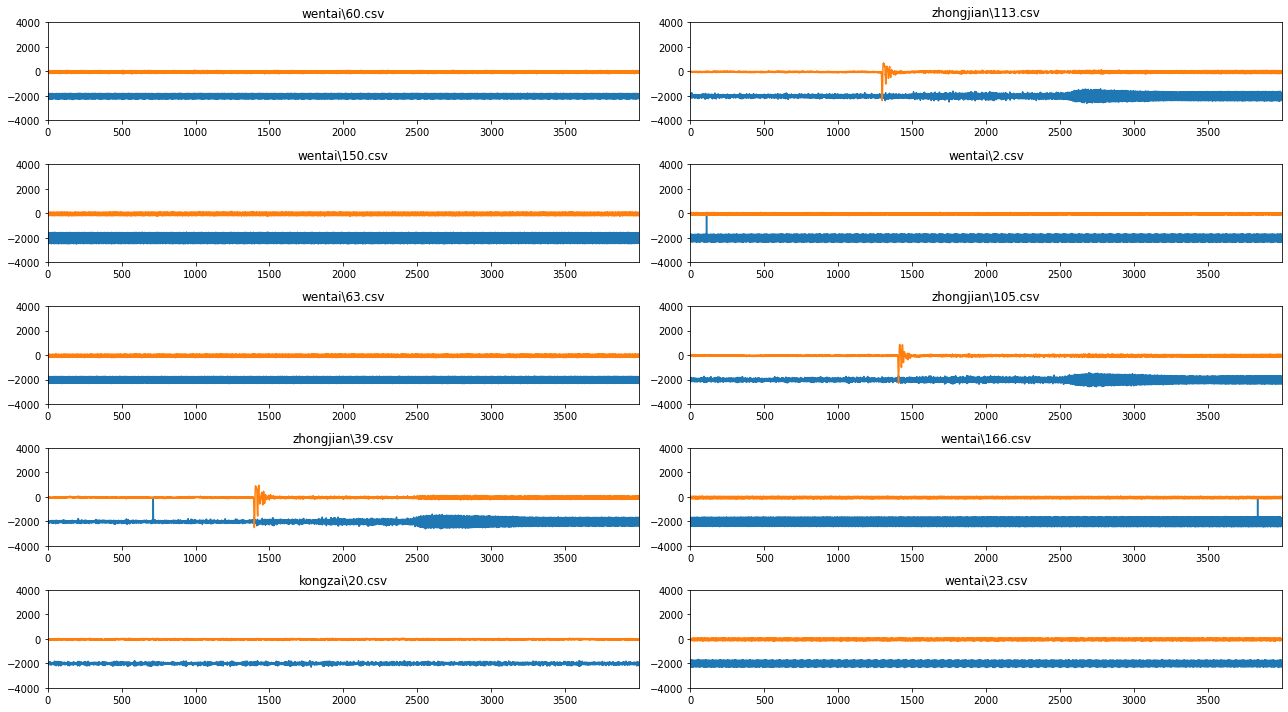

In [5]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Plot some captures
random.seed(10)
unique_rands = random.sample(range(len(x_recordings)), 10)
plt.figure(figsize=(18, 10))
for i, n in enumerate(unique_rands):
    plt.subplot(5, 2, i + 1)
    plt.margins(x=0, y=-0.25)
    plt.plot(x_recordings[n])
    plt.ylim(-4000, 4000)  # 4000 mg acc. range
    plt.title(recordings_filenames[n].split('/')[-1])
plt.tight_layout()
plt.show()

## Frame data

Each capture is framed into smaller windows. The window size will be the input dimension for the neural network. Optional overlapping can be added to further increase the number of points in our data for training and testing.

Here we are dividing the dataset into 1 second frames (26 samples at 26 Hz):

In [6]:
import numpy as np

def frame(x, frame_len, hop_len):
    '''Slice a 3D data array into (overlapping) frames.
    
    Example
    --------
    >>> x = np.array([[0, 1, 2],
                      [10, 11, 12],
                      [20, 21, 22],
                      [30, 31, 32],
                      [40, 41, 42],
                      [50, 51, 52],
                      [60, 61, 62]])
    >>> frames = x.frame(x, 3, 2)
    >>> x.shape
    (7, 3)
    >>> frames.shape
    (3, 3, 3)
    '''

    assert(x.shape == (len(x), 2))
    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)

    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

x_frames = []
y_frames = []
for i in range(x_recordings.shape[0]):
    # frames = frame(x_recordings[i], 26, 26) # no overlap
    frames = frame(x_recordings[i], 4000, 2000) # 50% overlap
    x_frames.append(frames)
    y_frames.append(np.full(frames.shape[0], y_recordings[i]))

print(np.array(x_frames).shape)
x_frames = np.concatenate(x_frames)
y_frames = np.concatenate(y_frames)
print(x_frames.shape)

# Each output label is an integer between 0 and 2:
print(y_frames.shape)
print(labels)

(503, 1, 4000, 2)
(503, 4000, 2)
(503,)
['zhongjian', 'wentai', 'kongzai']


## Preprocessing the dataset

To improve the model's performance, it is recommended to perform some kind of pre-processing on the input data before feeding them to the neural network model. Data pre-processing can include filtering, gravity rotation and/or suppression as it is done in [FP-AI-SENSING1]. In this example, a simple data scaling will suffice.

Data scaling can be achieved by normalizing or standardizing input data. In this example, data is normalized into floating point values between `-1.0` and `1.0` by dividing them by the sensor's full range (`4000 mg`).

[FP-AI-SENSING1]:https://www.st.com/en/embedded-software/fp-ai-sensing1.html

In [7]:
# Normalize input data between [-1;1]
x_frames_normed = x_frames / 4000

### Preparing the dataset (train, test, split)
The dataset is split into a _train_ and _test_ set. The data is first shuffled and then split with 25% reserved for model evaluation and testing purposes.

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_frames_normed, y_frames, test_size=0.25)

print("Trainning samples:", x_train.shape)
print("Testing samples:", x_test.shape)

Trainning samples: (377, 4000, 2)
Testing samples: (126, 4000, 2)


## Creating the model

Let's create a classifier model using Keras.

Build the tf.keras.Sequential model by stacking layers. Choose an optimizer and loss function for training:

In [9]:

from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [10]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [11]:
# Create the teacher
teacher = keras.Sequential(
    [
        keras.Input(shape=(4000, 2)),
        layers.Conv1D(256, 3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling1D(pool_size=2, strides=1, padding="same"),
        layers.Conv1D(512, 3, strides=2, padding="same"),
        layers.Flatten(),
        layers.Dense(7),
    ],
    name="teacher",
)

# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(4000, 2)),
        layers.Conv1D(32, 3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling1D(pool_size=2, strides=1, padding="same"),
        layers.Conv1D(16, 3, strides=2, padding="same"),
        layers.Flatten(),
        layers.Dense(7),
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

In [12]:
# Train teacher as usual
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate teacher on data.
teacher.fit(x_train, y_train, epochs=20)
teacher.evaluate(x_test, y_test)

Epoch 1/20
12/12 [==============================] - 1s 51ms/step - loss: 2.7771 - sparse_categorical_accuracy: 0.3316
Epoch 2/20
12/12 [==============================] - 0s 35ms/step - loss: 0.9558 - sparse_categorical_accuracy: 0.5172
Epoch 3/20
12/12 [==============================] - 0s 35ms/step - loss: 0.2966 - sparse_categorical_accuracy: 0.9231
Epoch 4/20
12/12 [==============================] - 0s 36ms/step - loss: 0.0446 - sparse_categorical_accuracy: 1.0000
Epoch 5/20
12/12 [==============================] - 0s 36ms/step - loss: 0.0163 - sparse_categorical_accuracy: 0.9973
Epoch 6/20
12/12 [==============================] - 0s 36ms/step - loss: 0.0074 - sparse_categorical_accuracy: 1.0000
Epoch 7/20
12/12 [==============================] - 0s 36ms/step - loss: 0.0062 - sparse_categorical_accuracy: 1.0000
Epoch 8/20
12/12 [==============================] - 0s 36ms/step - loss: 0.0037 - sparse_categorical_accuracy: 1.0000
Epoch 9/20
12/12 [==============================] - 0s 3

[0.019803905859589577, 0.9920634627342224]

In [13]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(x_train, y_train, epochs=20)

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Epoch 1/20
12/12 [==============================] - 0s 26ms/step - sparse_categorical_accuracy: 0.3210 - student_loss: 1.6459 - distillation_loss: 15.2718
Epoch 2/20
12/12 [==============================] - 0s 15ms/step - sparse_categorical_accuracy: 0.3581 - student_loss: 1.4051 - distillation_loss: 14.2305
Epoch 3/20
12/12 [==============================] - 0s 15ms/step - sparse_categorical_accuracy: 0.7507 - student_loss: 0.7927 - distillation_loss: 12.2820
Epoch 4/20
12/12 [==============================] - 0s 15ms/step - sparse_categorical_accuracy: 0.7825 - student_loss: 0.5001 - distillation_loss: 9.6326
Epoch 5/20
12/12 [==============================] - 0s 15ms/step - sparse_categorical_accuracy: 0.9735 - student_loss: 0.1860 - distillation_loss: 5.9221
Epoch 6/20
12/12 [==============================] - 0s 16ms/step - sparse_categorical_accuracy: 0.9894 - student_loss: 0.0766 - distillation_loss: 3.2092
Epoch 7/20
12/12 [==============================] - 0s 16ms/step - sparse

0.9920634627342224

In [14]:
# Train student as doen usually
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

# Train and evaluate student trained from scratch.
student_scratch.fit(x_train, y_train, epochs=20)
student_scratch.evaluate(x_test, y_test)

Epoch 1/20
12/12 [==============================] - 0s 24ms/step - loss: 1.1398 - sparse_categorical_accuracy: 0.3767
Epoch 2/20
12/12 [==============================] - 0s 4ms/step - loss: 1.0215 - sparse_categorical_accuracy: 0.4668
Epoch 3/20
12/12 [==============================] - 0s 4ms/step - loss: 0.9129 - sparse_categorical_accuracy: 0.5756
Epoch 4/20
12/12 [==============================] - 0s 4ms/step - loss: 0.7346 - sparse_categorical_accuracy: 0.8276
Epoch 5/20
12/12 [==============================] - 0s 4ms/step - loss: 0.5716 - sparse_categorical_accuracy: 0.9390
Epoch 6/20
12/12 [==============================] - 0s 3ms/step - loss: 0.3877 - sparse_categorical_accuracy: 0.9867
Epoch 7/20
12/12 [==============================] - 0s 3ms/step - loss: 0.2488 - sparse_categorical_accuracy: 0.9973
Epoch 8/20
12/12 [==============================] - 0s 3ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.9973
Epoch 9/20
12/12 [==============================] - 0s 3ms/step

[0.03713134676218033, 0.9920634627342224]

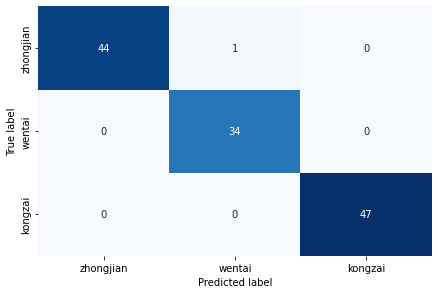

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Y_pred = student.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(confusion_matrix,
            annot=True,
            xticklabels=labels,
            yticklabels=labels,
            cmap=plt.cm.Blues,
            fmt='d', cbar=False)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [16]:
# Save the model into an HDF5 file ‘model.h5’
student.save('student.h5')

In [18]:
import tensorflow as tf

model = tf.keras.models.load_model('student.h5')


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('student.tflite', 'wb') as f:
  f.write(tflite_model)

In [19]:
teacher.save('teacher.h5')


In [20]:
import tensorflow as tf

model = tf.keras.models.load_model('teacher.h5')


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('teacher.tflite', 'wb') as f:
  f.write(tflite_model)
